In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm.notebook import tqdm
import librosa
import librosa.display
from random import shuffle
from skimage.transform import resize
import warnings


In [2]:
warnings.filterwarnings('ignore')

### LISTAGE DES FICHIERS CONTENUS DANS *DATA*

In [201]:
from random import shuffle, seed

HOUSE_FOLDER = "/home/george/code/clumzy/electronic_tagger/DATA/HOUSE"
TECHNO_FOLDER = "/home/george/code/clumzy/electronic_tagger/DATA/TECHNO"

exts = ['*.mp3', '*.aiff', '*.flac','*.wav']

house_files = [f for ext in exts for f in glob(os.path.join(HOUSE_FOLDER, ext))]
techno_files = [f for ext in exts for f in glob(os.path.join(TECHNO_FOLDER, ext))]
seed(0)
shuffle(house_files)
seed(0)
shuffle(techno_files)

In [4]:
len(house_files), len(techno_files)

(533, 736)

### FEATURE MAKER FUNCTION & SCALER FUNCTION

Ces fonctions nous servent à scaler et créer **l'image feature** pour un fichier donné.

In [242]:
import pydub

def rgb_transform(data):
    return (((data+abs(data.min()))/(data+abs(data.min())).max())*255).astype(np.uint8)

def get_from_pydub(file, normalized=True, num_sample=6, sample_length=5):
    NUM_SAMPLE = num_sample
    song = pydub.AudioSegment.from_file(file).set_channels(1)
    SAMPLE_LENGTH = sample_length*1000
    # LA CHANSON EST DECOUPEE EN NUM_SAMPLES MORCEAUX, DE LONGEUR SAMPLE_LENGTH(SECONDES)
    song_inter = np.linspace(0,(len(song)-(SAMPLE_LENGTH+10000)),NUM_SAMPLE).astype(int)
    y = np.hstack([song[song_inter[i]:song_inter[i]+SAMPLE_LENGTH].get_array_of_samples() for i in range(0,NUM_SAMPLE)])
    if normalized:
        return song.frame_rate, np.float32(y) / 2**15
    else:
        return song.frame_rate, y

def song_to_img(file, hop_length=2048,num_sample=6, sample_length=5, sample_rate=44100):
    # VALEUR TEMPORAIRE DE HAUTEUR D'IMAGE, A REVOIR PLUS TARD /!\
    warnings.filterwarnings('ignore')
    HOP_LENGTH = hop_length
    NUM_SAMPLE = num_sample
    SAMPLE_LENGTH = sample_length
    SAMPLING_RATE, song_extracts = get_from_pydub(
        file, 
        normalized=True,
        num_sample=NUM_SAMPLE,
        sample_length=SAMPLE_LENGTH)
    
    #CALCUL DU CONSTANT Q
    if sample_rate != SAMPLING_RATE: print(file)
    constant_q_temp = librosa.cqt(song_extracts, hop_length=HOP_LENGTH, sr=SAMPLING_RATE)
    constant_q = librosa.amplitude_to_db(np.abs(constant_q_temp))
    #CALCUL DU MFCC, LES FREQUENCES QUE L'ON ENTEND
    ## CE FEATURE NE MARCHE PAS TRES BIEN /!\
    #mfcc_song = librosa.feature.mfcc(y=song_extracts, n_mfcc=13, sr=SAMPLING_RATE, lifter=512, hop_length=HOP_LENGTH)

    #CALCUL DU CHROMAGRAMME (LES NOTES)
    ## VERSION CENS
    chroma = librosa.feature.chroma_cens(y=song_extracts, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_chroma=12, win_len_smooth=12, C=constant_q_temp)
    ## VERSION "CLASSIQUE"
    chroma2 = librosa.feature.chroma_cqt(y=song_extracts, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_chroma=12, C=constant_q_temp)
    #CREATION DE LA SHAPE FINALE A PARTIR DES PLUS GRANDES VALEURS DE NOS TROIS FEATURES
    IM_HEIGHT = max(constant_q.shape[0], chroma.shape[0], chroma2.shape[0])
    IM_WIDTH = max(constant_q.shape[1], chroma.shape[1], chroma2.shape[1])
    IM_SHAPE = (IM_HEIGHT, IM_WIDTH)

    r = rgb_transform(resize(constant_q, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

    g = rgb_transform(resize(chroma, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

    b = rgb_transform(resize(chroma2, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)
    
    rgb = np.dstack((r,g,b)).astype(np.uint8)
    return rgb

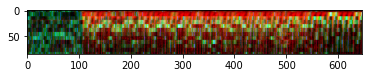

In [244]:
plt.imshow(song_to_img(house_files[1]))

### EXEMPLE D'UNE CREATION DE FEATURES

In [245]:
SONG_NUM = 1
HOP_LENGTH = 1024
NUM_SAMPLE = 5
SAMPLE_LENGTH = 6
house_files[SONG_NUM]

'/home/george/code/clumzy/electronic_tagger/DATA/HOUSE/Rossi. - Applause.mp3'

In [246]:
SAMPLING_RATE, song_extracts = get_from_pydub(
    house_files[SONG_NUM], 
    normalized=True,
    num_sample=NUM_SAMPLE,
    sample_length=SAMPLE_LENGTH)

In [248]:
song2 = librosa.load(house_files[SONG_NUM], sr=44100)

In [254]:
#CALCUL DU CONSTANT Q
constant_q_temp = librosa.cqt(song_extracts, hop_length=HOP_LENGTH, sr=SAMPLING_RATE)
constant_q = librosa.amplitude_to_db(np.abs(constant_q_temp))
#CALCUL DU MFCC, LES FREQUENCES QUE L'ON ENTEND
## CE FEATURE NE MARCHE PAS TRES BIEN /!\
#mfcc_song = librosa.feature.mfcc(y=song_extracts, n_mfcc=13, sr=SAMPLING_RATE, lifter=512, hop_length=HOP_LENGTH)

#CALCUL DU CHROMAGRAMME (LES NOTES)
## VERSION CENS
chroma = librosa.feature.chroma_cens(y=song_extracts, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_chroma=12, win_len_smooth=12, C=constant_q_temp)
## VERSION "CLASSIQUE"
chroma2 = librosa.feature.chroma_cqt(y=song_extracts, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_chroma=12, C=constant_q_temp)

In [250]:
constant_q.shape, chroma.shape, chroma2.shape

((84, 1292), (12, 1292), (12, 1292))

In [255]:
#CREATION DE LA SHAPE FINALE A PARTIR DES PLUS GRANDES VALEURS DE NOS TROIS FEATURES
IM_HEIGHT = max(constant_q.shape[0], chroma.shape[0], chroma2.shape[0])
IM_WIDTH = max(constant_q.shape[1], chroma.shape[1], chroma2.shape[1])
IM_SHAPE = (IM_HEIGHT, IM_WIDTH)

r = rgb_transform(resize(constant_q, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

g = rgb_transform(resize(chroma, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

b = rgb_transform(resize(chroma2, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

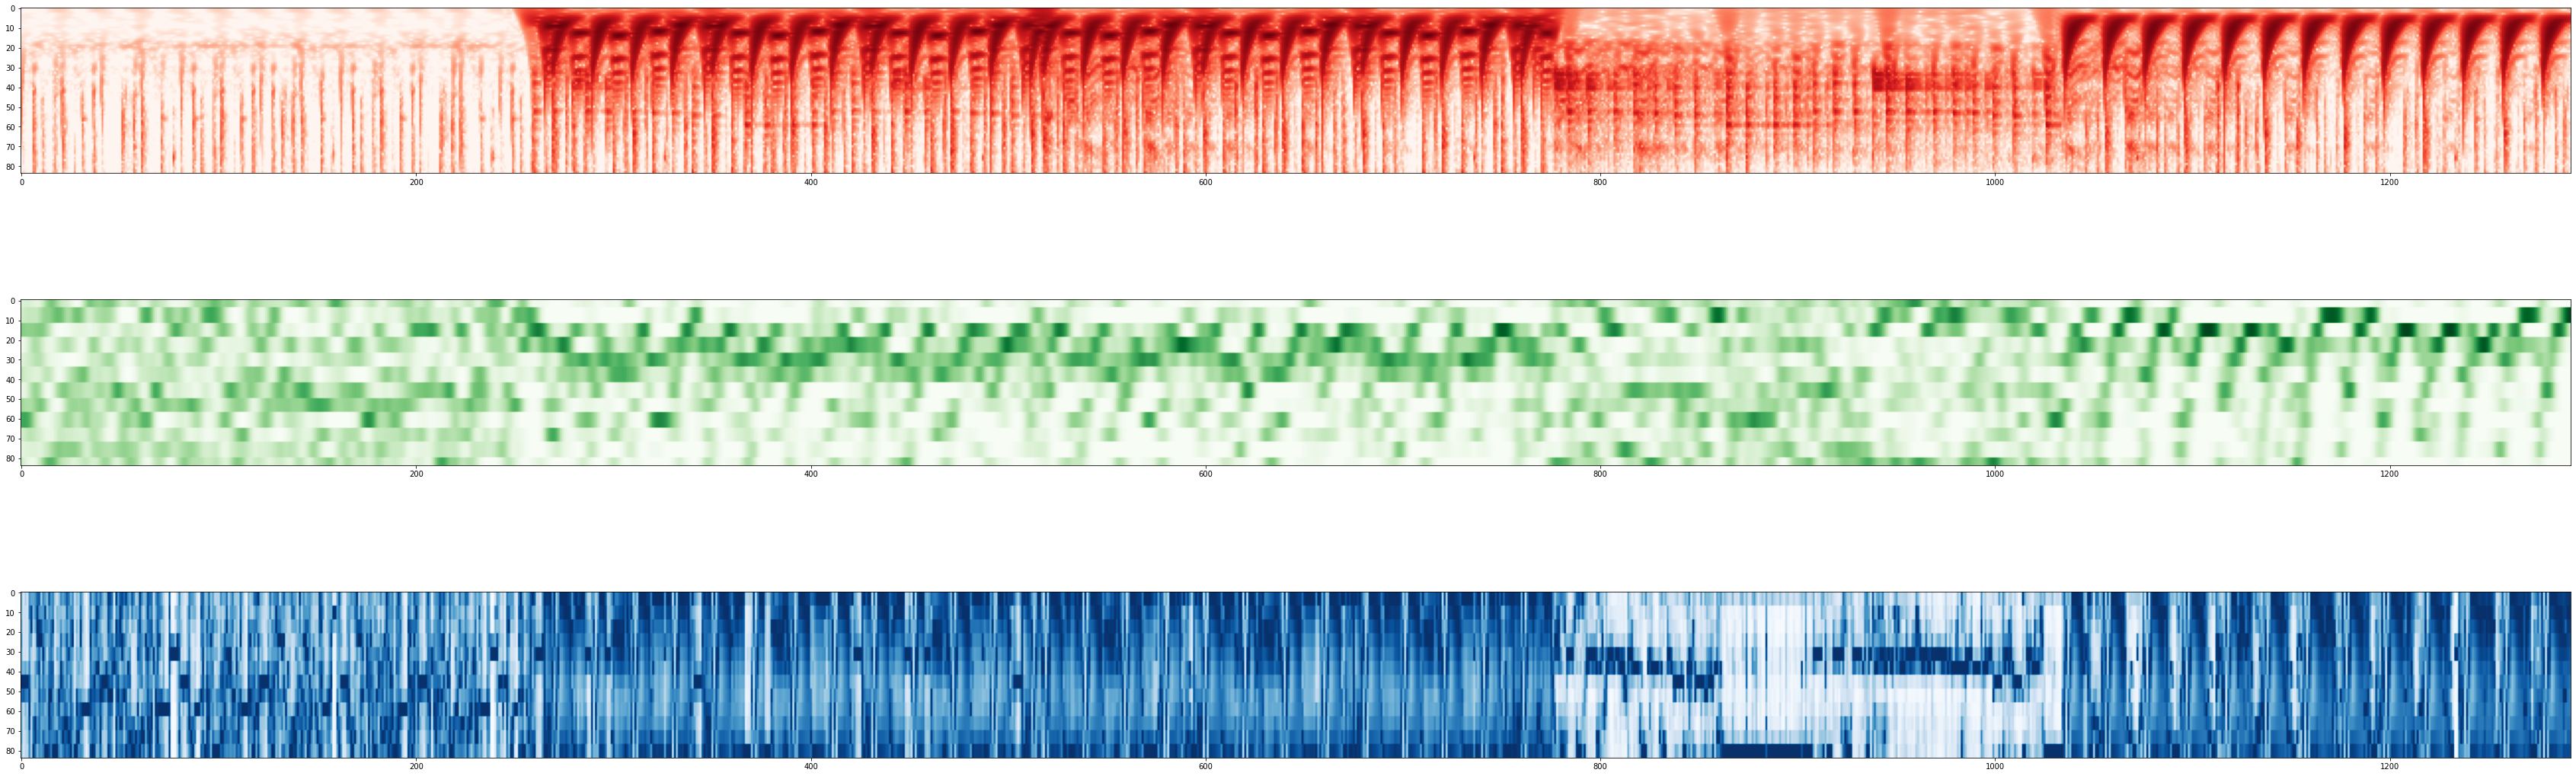

In [256]:
plt.figure(figsize=(60,20))
plt.subplot(3,1,1)
plt.imshow((r), cmap="Reds")
plt.subplot(3,1,2)
plt.imshow(g, cmap="Greens")
plt.subplot(3,1,3)
plt.imshow(b, cmap="Blues")
plt.show()

In [150]:
rgb = np.dstack((r,g,b))
plt.figure(figsize=(60,8))
plt.imshow(rgb)

### CREATION DES FEATURES POUR LA LISTE DES MUSIQUES

In [213]:
len(techno_files[START_SONG:START_SONG+HOW_MANY])

400

In [218]:
song_to_img(house_files[0], hop_length=1024, num_sample=5, sample_length = 6).shape

(84, 1292, 3)

In [223]:
from joblib import Parallel, delayed

START_SONG = 0
HOW_MANY = 400
ar1 = np.array(Parallel(n_jobs=4)(delayed(song_to_img)(house_file, hop_length=1024, num_sample=5, sample_length = 6) for house_file in tqdm(house_files[START_SONG:START_SONG+HOW_MANY])), dtype=np.uint8)
ar2 = np.array(Parallel(n_jobs=4)(delayed(song_to_img)(techno_file, hop_length=1024, num_sample=5, sample_length = 6) for techno_file in tqdm(techno_files[START_SONG:START_SONG+HOW_MANY])), dtype=np.uint8)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [224]:
X_1 = np.vstack([ar1, ar2])

X_2 = [os.path.basename(house_file) for house_file in tqdm(house_files[START_SONG:START_SONG+HOW_MANY])] + [os.path.basename(techno_file) for techno_file in tqdm(techno_files[START_SONG:START_SONG+HOW_MANY])]

X = (X_1,X_2)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

### EXPORT DES FEATURES

In [225]:
import pickle
pickle.dump( X, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images_2.pkl"), "wb" ) )

### CREATION DE LA TARGET: 1 = HOUSE et 0 = TECHNO

In [226]:
y = np.hstack([np.ones(len(X[0])//2),np.zeros(len(X[0])//2)]).astype(int)

### AFFICHAGE DES FEATURES

In [227]:
images = np.random.choice(range(X[0].shape[0]), 12, replace = False) #type: ignore
plt.figure(2, figsize=(24, 24))
for i in range(1, 13):
    plt.subplot(12, 1, i)
    plt.imshow(X[0][images[i-1]])
    plt.title(f"{X[1][images[i-1]]}\nlabel: {y[images[i-1]]}")
plt.tight_layout()
plt.show()